In [1]:
import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

/Users/aravind/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration and measuring Distortion 

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,
                                                   img.shape[0:2], 
                                                   None, None)

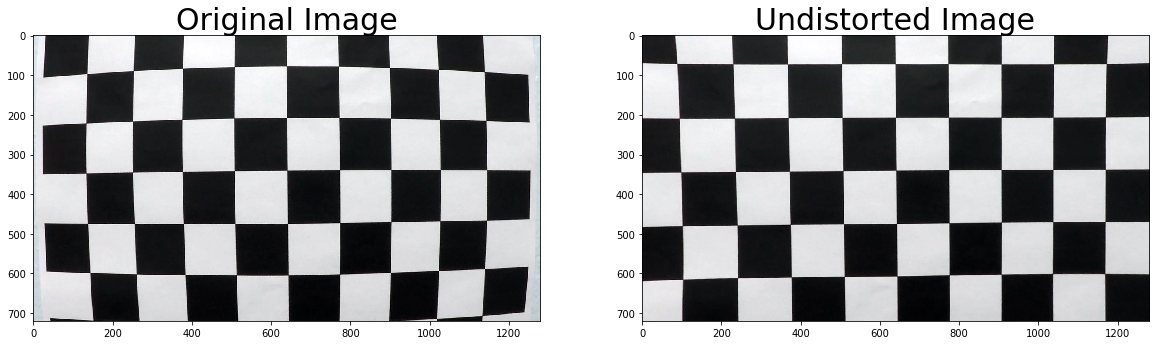

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig('output_images/distortion_corrected.png')

## Pipeline

### Using color spaces and gradients to obtain binary thresholded image

In [4]:
# Edit this function to create your own pipeline.
def sobel_and_gradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space 
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary,combined_binary

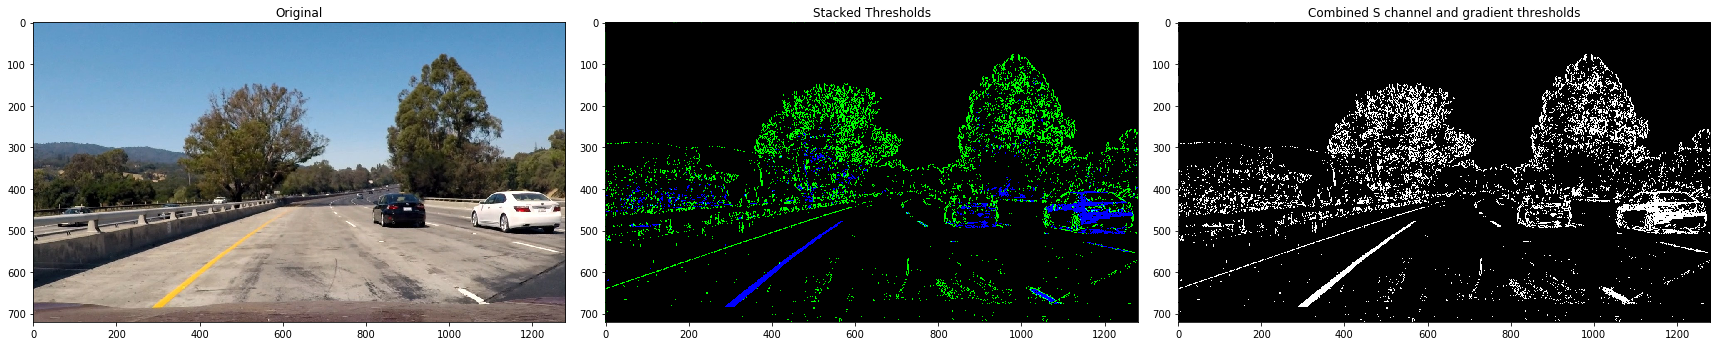

In [5]:
image = mpimg.imread('test_images/test1.jpg')
color_binary,combined_binary = sobel_and_gradient(image)
# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original')
ax2.imshow(color_binary)
ax2.set_title('Stacked Thresholds')
ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined S channel and gradient thresholds')
f.tight_layout()
f.savefig('output_images/hsv_and_gradient.png')

### Applying Perspective transform

In [6]:
img_size=(1280, 720)
src=np.float32([[585,467],[704,467],[910,598],[400,598]])
x_offset=300
y_offset=100
dst=np.float32([[x_offset, y_offset], [img_size[0]-x_offset, y_offset], 
                                     [img_size[0]-x_offset, img_size[1]-y_offset], 
                                     [x_offset, img_size[1]-y_offset]])

straight_line_image_warp_matrix = cv2.getPerspectiveTransform(src, dst)
M=straight_line_image_warp_matrix
Minv=cv2.getPerspectiveTransform(dst, src)

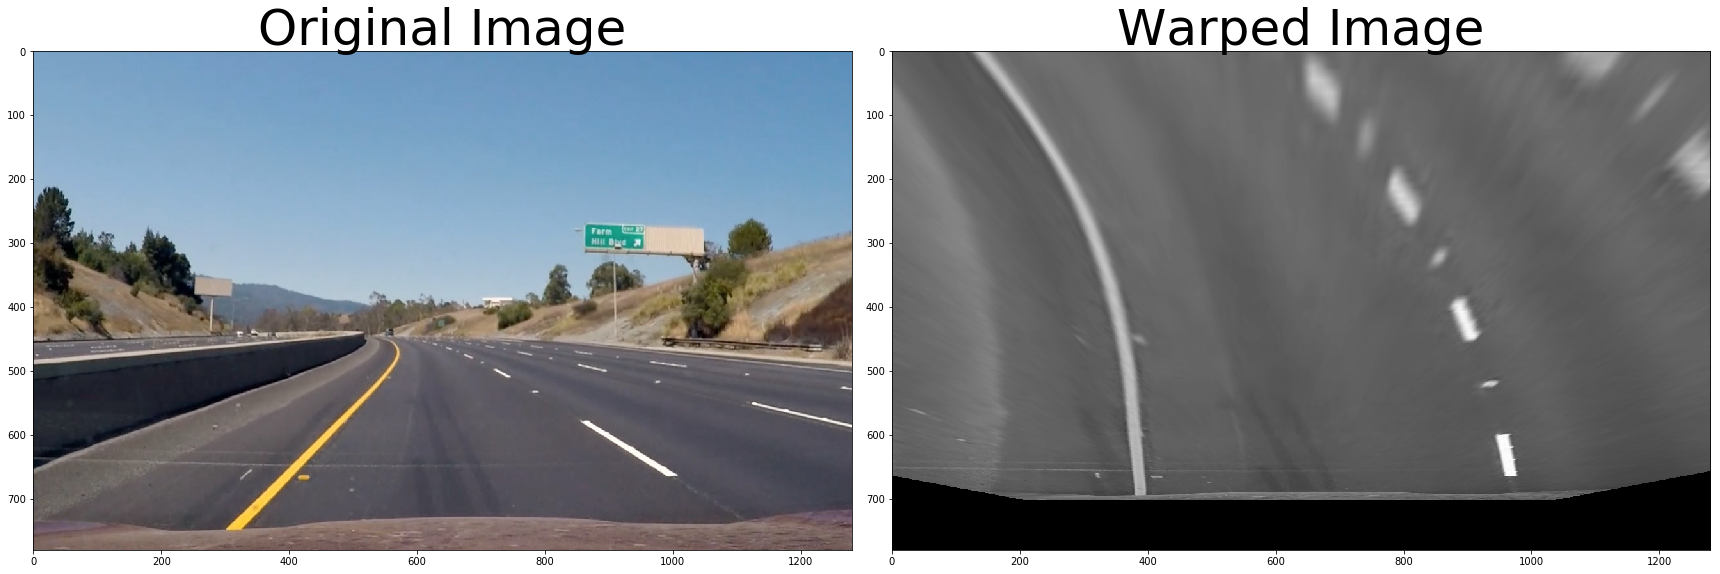

In [7]:
image = mpimg.imread('test_images/test7.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_size = (gray.shape[1], gray.shape[0])
test7_warped = cv2.warpPerspective(gray, straight_line_image_warp_matrix, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(test7_warped,cmap="gray")
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.tight_layout()
f.savefig('output_images/warp.png')

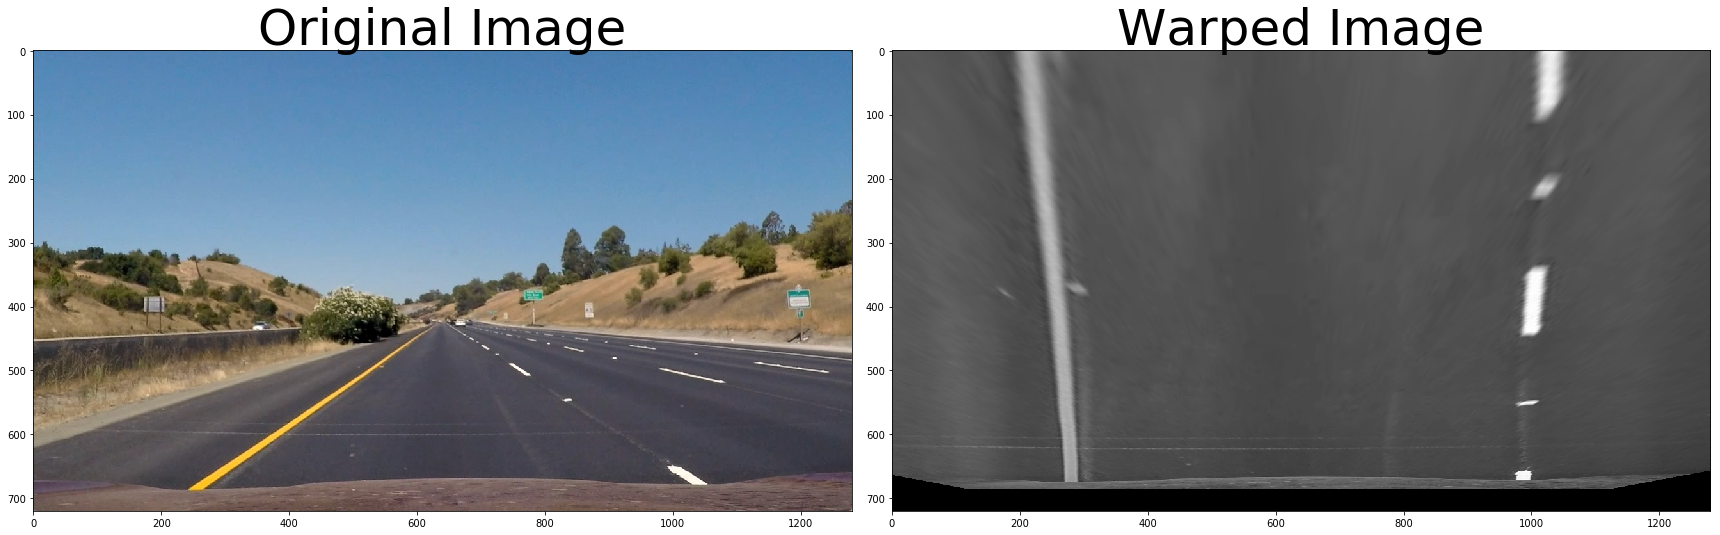

In [8]:
image = mpimg.imread('test_images/straight_lines1.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
img_size = (gray.shape[1], gray.shape[0])
warped = cv2.warpPerspective(gray, straight_line_image_warp_matrix, img_size)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped,cmap="gray")
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
f.tight_layout()
f.savefig('output_images/warp2.png')

### Identifying Lane Lines and Polynomial Fitting

In [9]:
def sliding_window(nonzero,leftx_base,rightx_base,nwindows,image_height,window_height,margin,minpix):
    left_lane_inds = []
    right_lane_inds = []
    # Current positions to be updated for each window
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Step through the windows one by one

    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = image_height - (window+1)*window_height
        win_y_high = image_height - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds,right_lane_inds

def lane_lines(binary_warped,left_fit=np.array([False]),right_fit=np.array([False])):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# Choose the number of sliding windows
    nwindows = 9
# Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

# Set the width of the windows +/- margin
    margin = 100
# Set minimum number of pixels found to recenter window
    minpix = 50

# Trying to LookAhead 
    if len(left_fit)==3 and len(right_fit)==3:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    else:
        left_lane_inds,right_lane_inds=sliding_window(nonzero,leftx_base,rightx_base,nwindows,binary_warped.shape[0],window_height,margin,minpix)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return leftx,lefty,rightx,righty

def fit_points(leftx,lefty,rightx,righty):
    # Define conversions in x and y from pixels space to meters
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit


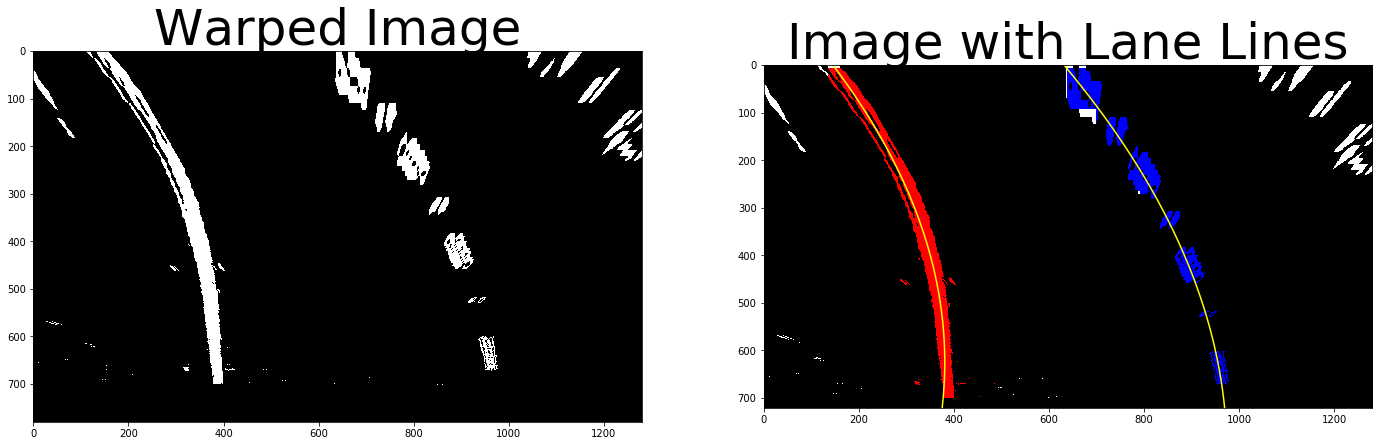

In [10]:
img = mpimg.imread('test_images/test7.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
undist = cv2.undistort(img, mtx, dist, None, mtx)
color_binary,combined_binary=sobel_and_gradient(undist)
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(combined_binary, M, img_size)
ax1.imshow(warped,cmap="gray")
ax1.set_title('Warped Image', fontsize=50)
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx_1,lefty_1,rightx_1,righty_1=lane_lines(warped)
left_fit,right_fit=fit_points(leftx_1,lefty_1,rightx_1,righty_1)
ploty = np.linspace(0, img.shape[0]-1,  img.shape[0])    
left_fitx_1 = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx_1 = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img = np.dstack((warped, warped, warped))*255
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
out_img[lefty_1, leftx_1] = [255, 0, 0]
out_img[righty_1, rightx_1] = [0, 0, 255]
ax2.imshow(out_img)
ax2.set_title('Image with Lane Lines', fontsize=50)
ax2.plot(left_fitx_1, ploty, color='yellow')
ax2.plot(right_fitx_1, ploty, color='yellow')
ax2.set_xlim(0, 1280)
ax2.set_ylim(720, 0)
f.savefig('output_images/test7_lane_lines.png')


### Measuring Radius of Curvature and Lane Offset

In [11]:
def curvature(leftx,lefty,rightx,righty,height):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lefty=lefty*ym_per_pix
    leftx=leftx*xm_per_pix
    rightx=rightx*xm_per_pix
    righty=righty*ym_per_pix

    y_eval = height
    left_fit_cr,right_fit_cr = fit_points(leftx,lefty,rightx,righty)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm') 
    return left_curverad,right_curverad
    

def distance_from_center(left_fitx,right_fitx,width):
    x_left=left_fitx[-1]
    x_right=right_fitx[-1]
    lane_center=(x_left+x_right)/2
    pic_center=width/2
    x_offset=abs(lane_center-pic_center)
    #print("pic_center",pic_center,"lane_center",lane_center,"x_offset",x_offset)
    xm_per_pix = 3.7/700
    return round(x_offset*xm_per_pix,2)
    
l,r=curvature(leftx_1,lefty_1,rightx_1,righty_1,img_size[1])

print("Curvature Left Lane : %7.2f"%l,"Curvature Right Lane :%7.2f"%r)

print ("Offset : %3.2f"%distance_from_center(left_fitx_1,right_fitx_1,img_size[0]))


Curvature Left Lane :  273.10 Curvature Right Lane : 320.98
Offset : 0.16


### Other Optimizations

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def reset(self):
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
  
    def __init__(self):
        self.cache_length=3
        # was the line detected in the last iteration?
        self.reset()
  
    def valid_current_fit(self):
        return len(self.current_fit)==3
        
    def update(self):
        if len(self.recent_xfitted)>self.cache_length:
            recent=len(self.recent_xfitted)-self.cache_length
            self.recent_xfitted=self.recent_xfitted[recent:]
            
        self.bestx=np.average(np.array(self.recent_xfitted),axis=0)

LEFT_LANE=Line()
RIGHT_LANE=Line() 

### Plotting Lane Area and putting it all together

In [13]:
def clear_lines():
    LEFT_LANE.reset()
    RIGHT_LANE.reset()

def sanity_check(fit,x,y,fit_x,curvature):
    return True

def draw_lane_area(warped,undist,left_fitx,right_fitx,Minv,height):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    ploty = np.linspace(0, height-1,  height)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def process_image(img,M=M,Minv=Minv,left_lane=LEFT_LANE,right_lane=RIGHT_LANE):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary,combined_binary=sobel_and_gradient(undist)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(combined_binary, M, img_size)
    previous_left_fit=np.array([False])
    previous_right_fit=np.array([False])
    if left_lane.valid_current_fit() and right_lane.valid_current_fit():
        previous_left_fit=left_lane.current_fit
        previous_right_fit=right_lane.current_fit
        
    leftx,lefty,rightx,righty=lane_lines(warped,previous_left_fit,previous_right_fit)
    left_fit,right_fit=fit_points(leftx,lefty,rightx,righty)
    ploty = np.linspace(0, img.shape[0]-1,  img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_curverad,right_curverad=curvature(leftx,lefty,rightx,righty, img.shape[0])
    offset=distance_from_center(left_fitx,right_fitx,img.shape[1])
    avg_curvature=round((left_curverad+right_curverad)/2,2)

    radius_text='Radius of curvature='+str(avg_curvature) + " m"
    offset_text="Distance from center="+str(offset)+ " m"
    radius_pos=(50,50)
    offset_pos=(50,100)
    final_image=draw_lane_area(warped,undist,left_fitx,right_fitx,Minv,img.shape[0])
    cv2.putText(final_image,radius_text,radius_pos,cv2.FONT_HERSHEY_SIMPLEX,2, (255,255,255),3,cv2.LINE_AA)
    cv2.putText(final_image,offset_text,offset_pos,cv2.FONT_HERSHEY_SIMPLEX,2, (255,255,255),3,cv2.LINE_AA)
    
    if sanity_check(left_fit,leftx,lefty,left_fitx,left_curverad):
        left_lane.radius_of_curvature=left_curverad
        left_lane.current_fit=left_fit
        left_lane.recent_xfitted.append(left_fitx)
        left_lane.allx=leftx
        left_lane.ally = lefty
        left_lane.update()

    if sanity_check(right_fit,rightx,righty,right_fitx,right_curverad):
        right_lane.radius_of_curvature=right_curverad
        right_lane.current_fit=right_fit
        right_lane.recent_xfitted.append(right_fitx)
        right_lane.allx=rightx
        right_lane.ally = righty
        right_lane.update()
        
    return final_image

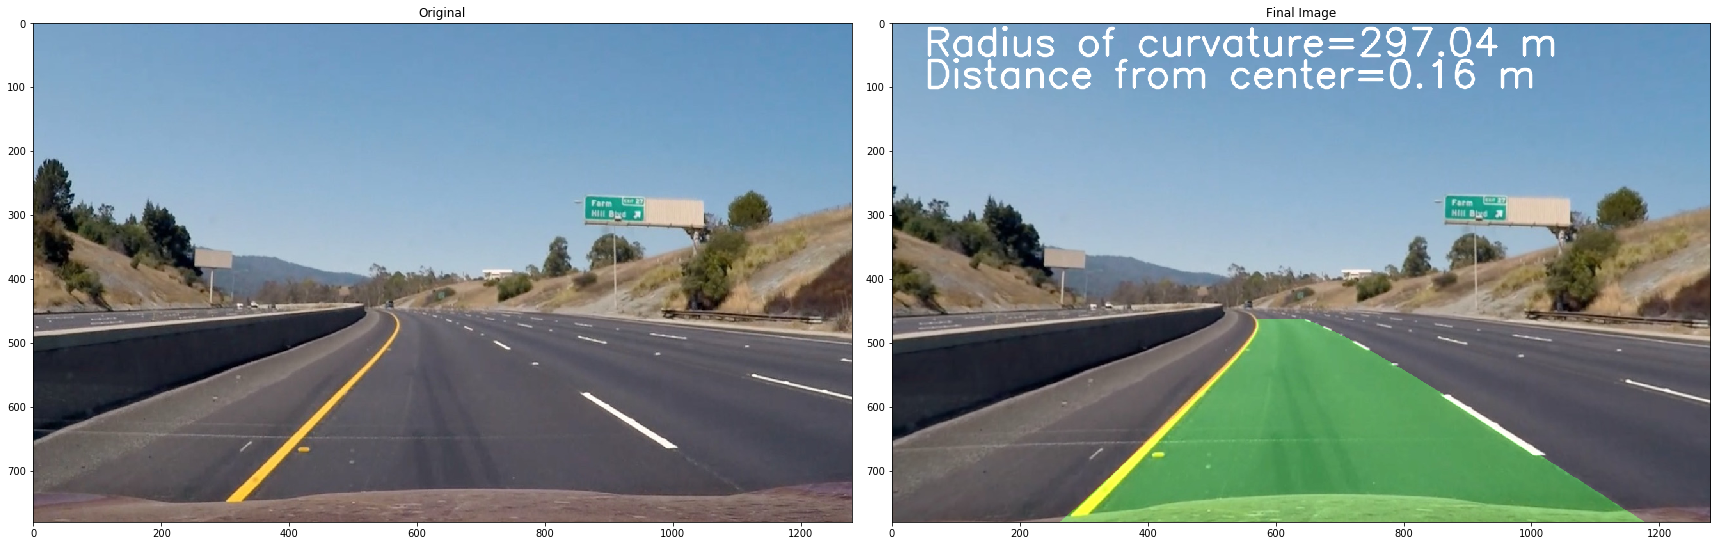

In [14]:
image = mpimg.imread('test_images/test7.jpg')
clear_lines()
result=process_image(image,M,Minv)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original')
ax2.imshow(result,cmap="gray")
ax2.set_title('Final Image')
f.tight_layout()
f.savefig('output_images/test7_color_fit_lines.png')
#clear_lines()

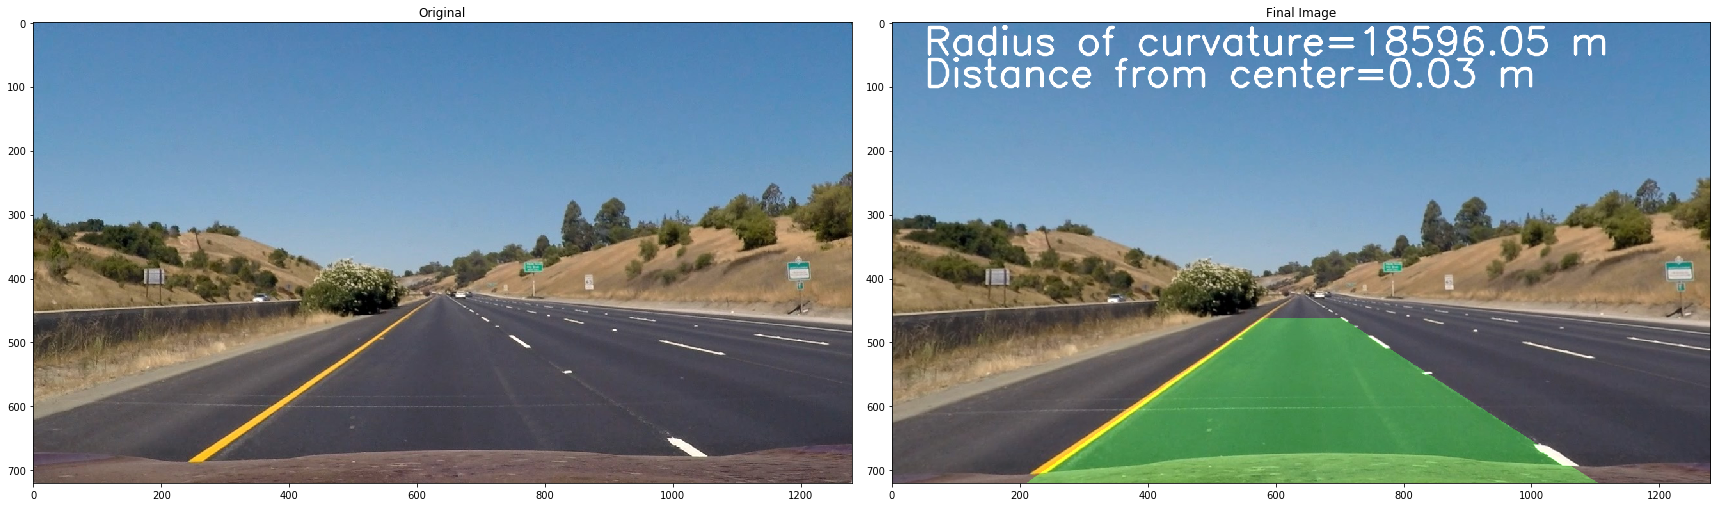

In [15]:
clear_lines()
image = mpimg.imread('test_images/straight_lines1.jpg')
result=process_image(image,M,Minv)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original')
ax2.imshow(result,cmap="gray")
ax2.set_title('Final Image')
f.tight_layout()
f.savefig('output_images/straight_lines1_color_fit_lines.png')


In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

2017-04-11 08:14:10  - py.warnings - WARNING - /Users/aravind/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [17]:
clear_lines()
white_output = 'lanes.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video lanes.mp4
[MoviePy] Writing video lanes.mp4


100%|█████████▉| 1260/1261 [03:48<00:00,  4.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lanes.mp4 

CPU times: user 3min 44s, sys: 48 s, total: 4min 32s
Wall time: 3min 50s


### Challenges

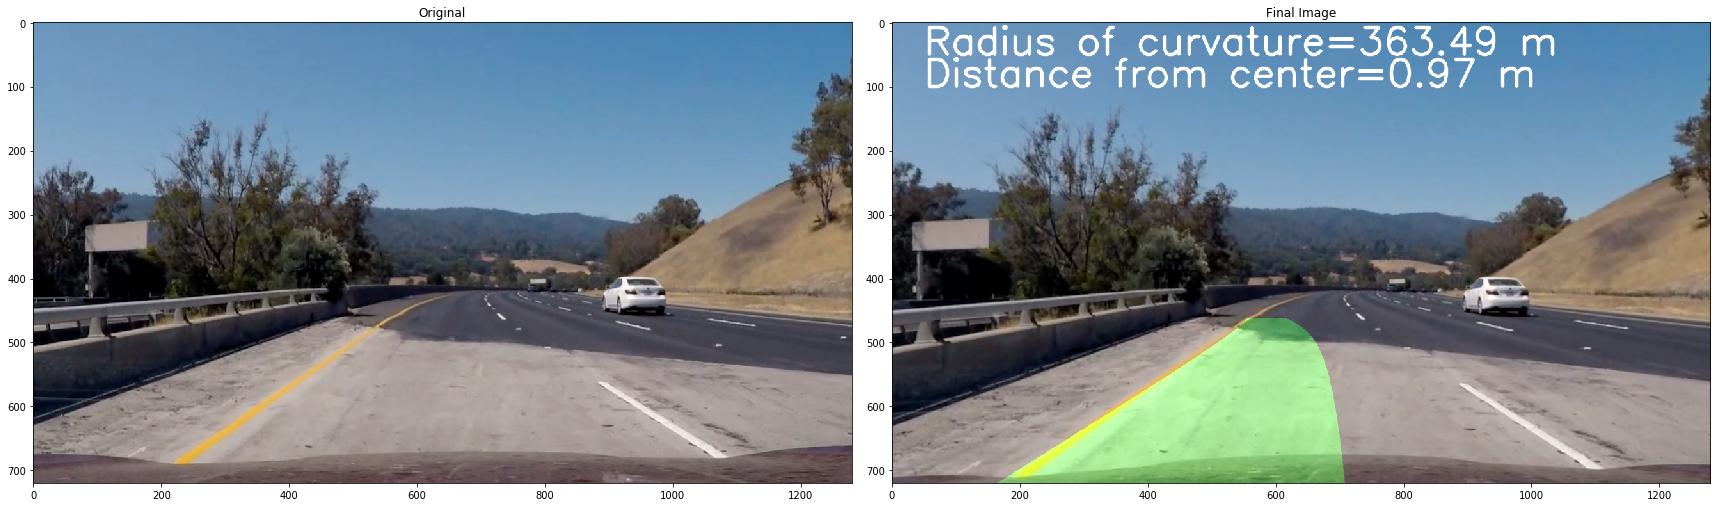

In [18]:
clear_lines()
image = mpimg.imread('test_images/test9.jpg')
result=process_image(image,M,Minv)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(image)
ax1.set_title('Original')
ax2.imshow(result,cmap="gray")
ax2.set_title('Final Image')
f.tight_layout()
f.savefig('output_images/shadow_challenge.png')